## ✒️ &nbsp; Code Modules & Helpful Function


In [94]:
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,tensorflow as tf
import pandas as pd,numpy as np,pylab as pl
from IPython.display import display,HTML
from sklearn.model_selection import train_test_split
import tensorflow.keras.optimizers as \
tko,tensorflow.keras.layers as tkl
np.set_printoptions(precision=6)

In [95]:
def preprocess(x):    
    return np.clip((x-.5)*2,-1,1)
def deprocess(x,img_size):
    x=np.array(np.clip((x/2+.5)*255,0,255),dtype=np.uint8) 
    return x.reshape(img_size,img_size)
def latent_samples(n_samples,sample_size):
    return np.random.normal(
        loc=0,scale=1,size=(n_samples,sample_size))
def display_images(generated_images,img_size):
    n_images=len(generated_images)
    rows=4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i],img_size)
        pl.subplot(rows,cols,i+1)
        pl.imshow(img,cmap=pl.cm.Greys)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()

## ✒️ Data Loading and Preprocessing

In [96]:
names=[['lowercase','uppercase'],
       [s for s in u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'],
       ['single-colored paper','striped paper',
        'squared paper','graph paper']]
path='https://raw.githubusercontent.com/'+\
     'OlgaBelitskaya/data/main/zip_letters/'
h5f='01_05_00.h5'
input_file=urllib.request.urlopen(path+h5f)
output_file=open(h5f,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
with h5py.File(h5f,'r') as f:
    keys=list(f.keys())
    print('file keys: '+', '.join(keys))
    images=np.array(f[keys[int(0)]])
    labels=[el.decode('utf-8') for el in f[keys[1]]]
    f.close()
images.shape,images.dtype,labels

file keys: images, labels


((1422, 32, 32, 3), dtype('<f4'), ['uppercase', 'е', 'single-colored paper'])

In [97]:
N=1400; sample_size=12
img_size=32; latent_size=128
latent_sample_in=latent_samples(1,img_size**2)
latent_sample_out=latent_samples(1,latent_size)
images=tf.image.resize(images[:N],[img_size,img_size]).numpy()
gray_images=np.dot(images[...,:3],[.299,.587,.114])

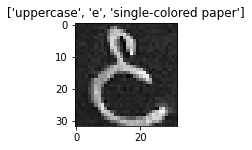

In [98]:
pl.figure(figsize=(2,3))
randi=np.random.randint(int(.9*N))
img=np.array(gray_images[randi])
pl.imshow(img.astype(float),cmap=pl.cm.Greys)
pl.tight_layout(); pl.title(labels); pl.show()

In [99]:
gray_images=gray_images.reshape(N,img_size**2)
gray_images.shape,gray_images.dtype

((1400, 1024), dtype('float64'))

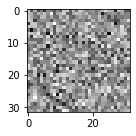

In [100]:
pl.figure(figsize=(2,3))
img0=np.squeeze(latent_sample_in).reshape(img_size,img_size)
pl.imshow(img0,cmap=pl.cm.Greys)
pl.tight_layout(); pl.show()

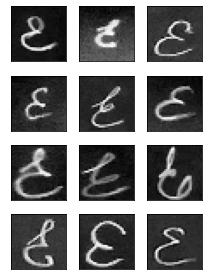

((1260, 1024), (140, 1024))

In [101]:
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
gray_images=gray_images[shuffle_ids]
X_train_real,X_test_real=train_test_split(gray_images,test_size=.1)
X_train_real=preprocess(X_train_real)
X_test_real=preprocess(X_test_real)
display_images(X_train_real[:sample_size],img_size)
X_train_real.shape,X_test_real.shape

## ✒️  Keras Simple GAN

In [102]:
discriminator=tf.keras.Sequential(
    [tkl.Dense(512,input_shape=(img_size**2,)),
     tkl.LeakyReLU(alpha=.01),
     tkl.Dense(1),
     tkl.Activation('sigmoid')],name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


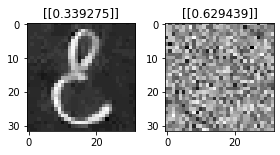

In [103]:
fig=pl.figure(figsize=(4,3))
ax=fig.add_subplot(121)
img=X_train_real[randi].reshape(1,img_size**2)
ax.set_title(discriminator.predict(img))
ax.imshow(img.reshape(img_size,img_size),cmap=pl.cm.Greys)
ax=fig.add_subplot(122)
ax.set_title(discriminator.predict(img0.reshape(1,img_size**2)))
ax.imshow(img0,cmap=pl.cm.Greys)
pl.tight_layout(); pl.show()

In [104]:
generator=tf.keras.Sequential(
    [tkl.Dense(512,input_shape=(latent_size,)),
     tkl.LeakyReLU(alpha=.01),
     tkl.Dense(img_size**2),
     tkl.Activation('tanh')],name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
activation_3 (Activation)    (None, 1024)              0         
Total params: 591,360
Trainable params: 591,360
Non-trainable params: 0
_________________________________________________________________


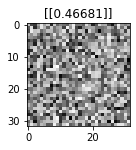

In [105]:
pl.figure(figsize=(2,3))
generated_latent_sample=generator.predict(latent_sample_out)
pl.title(discriminator.predict(generated_latent_sample))
pl.imshow(generated_latent_sample.reshape(img_size,img_size),
          cmap=pl.cm.Greys)
pl.tight_layout(); pl.show()

In [106]:
gan=tf.keras.Sequential([generator,discriminator]); gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 1024)              591360    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 525313    
Total params: 1,116,673
Trainable params: 1,116,673
Non-trainable params: 0
_________________________________________________________________



## ✒️  Model Building

In [107]:
def trainable(model,trainable):
    for layer in model.layers: layer.trainable=trainable
def simple_GAN(latent_size,img_size,g_hidden_size,d_hidden_size, 
               leaky_alpha,g_learning_rate,d_learning_rate):    
    tf.keras.backend.clear_session()    
    generator=tf.keras.Sequential(
        [tkl.Dense(g_hidden_size,input_shape=(latent_size,)),
         tkl.LeakyReLU(alpha=leaky_alpha),
         tkl.Dense(img_size**2),
         tkl.Activation('tanh')],name='generator')    
    discriminator=tf.keras.Sequential(
        [tkl.Dense(d_hidden_size,input_shape=(img_size**2,)),
         tkl.LeakyReLU(alpha=leaky_alpha),
         tkl.Dense(1),
         tkl.Activation('sigmoid')],name='discriminator')        
    gan=tf.keras.Sequential([generator,discriminator])    
    discriminator.compile(
        optimizer=tko.Adam(lr=d_learning_rate),loss='binary_crossentropy')
    gan.compile(
        optimizer=tko.Adam(lr=g_learning_rate),loss='binary_crossentropy')   
    return gan,generator,discriminator

In [108]:
latent_size    =128     
g_hidden_size  =1024  # generator
d_hidden_size  =1024  # discriminator
leaky_alpha    =.02
g_learning_rate=.0001 # generator
d_learning_rate=.0001  # discriminator
epochs         =200
batch_size     =64      
valid_size     =16     
smooth         =.1
def real_fake_labels(size):
    return np.ones([size,1]),np.zeros([size,1])
y_real5,y_fake5=real_fake_labels(5)
print('Real\n',y_real5,'\nFake\n',y_fake5)
y_train_real,y_train_fake=real_fake_labels(batch_size)
y_valid_real,y_valid_fake=real_fake_labels(valid_size)
gan,generator,discriminator=\
simple_GAN(latent_size,img_size,g_hidden_size,d_hidden_size,
           leaky_alpha,g_learning_rate,d_learning_rate)

Real
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
Fake
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


epoch: 25/200 | discriminator loss: 0.6304 | generator loss: 0.9224 | d_loss > g_loss: False


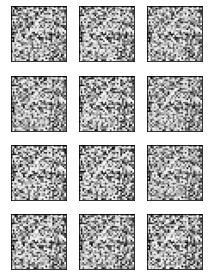

epoch: 50/200 | discriminator loss: 0.5549 | generator loss: 1.0745 | d_loss > g_loss: False


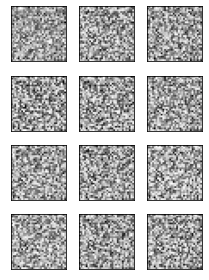

epoch: 75/200 | discriminator loss: 0.5845 | generator loss: 1.0456 | d_loss > g_loss: False


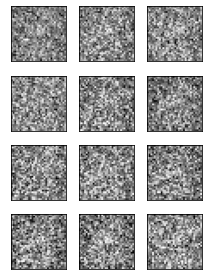

epoch: 100/200 | discriminator loss: 0.7205 | generator loss: 0.8748 | d_loss > g_loss: False


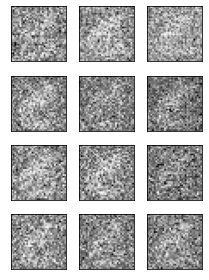

epoch: 125/200 | discriminator loss: 0.8020 | generator loss: 0.8167 | d_loss > g_loss: False


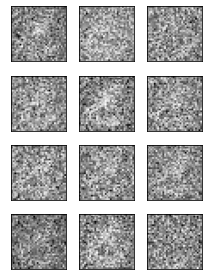

epoch: 150/200 | discriminator loss: 0.7986 | generator loss: 0.7539 | d_loss > g_loss: True


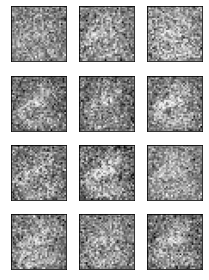

epoch: 175/200 | discriminator loss: 1.0011 | generator loss: 0.6662 | d_loss > g_loss: True


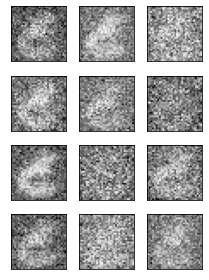

epoch: 200/200 | discriminator loss: 1.0895 | generator loss: 0.5596 | d_loss > g_loss: True


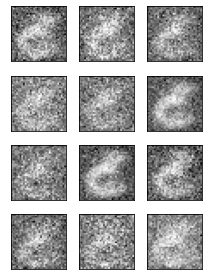

In [109]:
losses=[]
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real images
        X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]        
        # latent samples and generated letter images
        batch_latent_samples=latent_samples(batch_size,latent_size)
        X_batch_fake=generator.predict_on_batch(batch_latent_samples)        
        # train the discriminator to detect real and fake images
        trainable(discriminator,True)
        discriminator.train_on_batch(X_batch_real,y_train_real*(1.-smooth))
        discriminator.train_on_batch(X_batch_fake,y_train_fake)
        # train the generator via GAN
        trainable(discriminator,False)
        gan.train_on_batch(batch_latent_samples,y_train_real)    
    # evaluate
    X_valid_real=X_test_real[np.random.choice(
        len(X_test_real),valid_size,replace=False)]    
    valid_latent_samples=latent_samples(valid_size,latent_size)
    X_valid_fake=generator.predict_on_batch(valid_latent_samples)
    d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
    d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
    g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real)     
    losses.append((d_loss,g_loss))
    st='epoch: %d/%d | discriminator loss: %.4f | '+\
       'generator loss: %.4f | d_loss > g_loss: %s'
    if (e+1)%25==0:
        print(st%((e+1,epochs,d_loss,g_loss,d_loss>g_loss)))
        latent_examples=latent_samples(sample_size,latent_size)
        generated_letters=generator.predict(latent_examples)
        display_images(generated_letters,img_size)

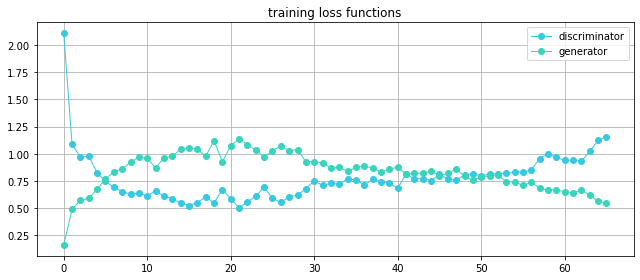

In [110]:
def display_loss(losses,n):
    indices=[i*n for i in range(len(losses)//n)]
    n_losses=np.array(losses)[indices,:]    
    pl.figure(figsize=(9,4))
    pl.plot(n_losses.T[0],'-o',c='#37c9e1',
            lw=1,label='discriminator')
    pl.plot(n_losses.T[1],'-o',c='#39d4be',
            lw=1,label='generator')
    pl.title('training loss functions')
    pl.legend(); pl.tight_layout(); pl.grid(); pl.show()
display_loss(losses,3)